In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import sklearn as sk
import scipy as sp

from statsmodels.datasets import get_rdataset
from statsmodels.regression import linear_model as lm
from statsmodels.discrete import discrete_model as dm
from statsmodels.tools import add_constant
from sklearn.preprocessing import PolynomialFeatures

In [4]:
df = get_rdataset('Auto', 'ISLR', True).data

In [5]:
train = df.sample(n = 196, random_state=2)
test = df[~df.index.isin(train.index)]

In [6]:
train_index = df.index.isin(train.index)
test_index = ~df.index.isin(train.index)

In [7]:
train.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
57,26.0,4,91.0,70,1955,20.5,71,1,plymouth cricket
72,19.0,3,70.0,97,2330,13.5,72,3,mazda rx2 coupe
316,24.3,4,151.0,90,3003,20.1,80,1,amc concord
182,33.0,4,91.0,53,1795,17.5,75,3,honda civic cvcc
310,41.5,4,98.0,76,2144,14.7,80,2,vw rabbit


In [8]:
def poly(data, n):
    pol = PolynomialFeatures(degree=n)
    X = pol.fit_transform( np.array(data).reshape(len(data), 1))
    return X

In [9]:
X = add_constant(train.horsepower)
model = lm.OLS(train.mpg, X).fit()
pred = model.predict( add_constant(df.horsepower) )
np.mean( (df.mpg - pred)[test_index]**2 )

25.10853905288965

In [10]:
pol2 = PolynomialFeatures(degree= 2)
X = pol2.fit_transform( np.array(train.horsepower).reshape(len(train), 1))
model = lm.OLS(train.mpg, X).fit()

X = pol2.fit_transform(np.array(df.horsepower).reshape(len(df), 1))
pred = model.predict( X )
np.mean( (df.mpg - pred)[test_index]**2 )

19.72253347049229

In [11]:
pol3 = PolynomialFeatures(degree= 3)
X = pol3.fit_transform( np.array(train.horsepower).reshape(len(train), 1))
model = lm.OLS(train.mpg, X).fit()

X = pol3.fit_transform(np.array(df.horsepower).reshape(len(df), 1))
pred = model.predict( X )
np.mean( (df.mpg - pred)[test_index]**2 )

19.92136786002233

## Leave one out

In [12]:
X = add_constant(df.horsepower)
model = lm.GLS(df.mpg, X).fit()
model.params

const         39.935861
horsepower    -0.157845
dtype: float64

In [13]:
X = add_constant(df.horsepower)
model = lm.OLS(df.mpg, X).fit()
model.params

const         39.935861
horsepower    -0.157845
dtype: float64

In [14]:
from sklearn.model_selection import cross_val_score, cross_validate, LeaveOneOut
from sklearn.linear_model import LinearRegression

In [15]:
def root_mean_sqr_error(model, X, y):
    ols = model.fit(X, y)
    pred = ols.predict(X)
    err = np.sqrt(((pred-y)**2).mean())
    return err

In [16]:
X = np.array(df.horsepower).reshape(len(df), 1)
model = LinearRegression()
cv = LeaveOneOut()
score = cross_val_score(model, X, df.mpg, cv = cv, scoring='neg_mean_squared_error')

In [17]:
np.abs(score).mean()

24.231513517929226

In [18]:
err = np.zeros(5)
for i in range(1,6):
    X = poly(df.horsepower, i)
    model = LinearRegression()
    cv = LeaveOneOut()
    scores = cross_val_score(model, X, df.mpg, cv = cv, scoring='neg_mean_squared_error')
    score = np.abs(scores).mean()
    err[i-1] = score
err

array([24.23151352, 19.24821312, 19.33498406, 19.42443031, 19.03320481])

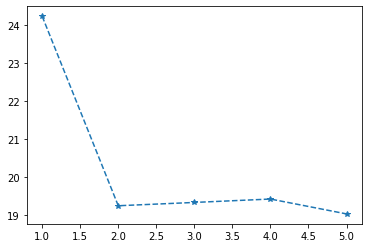

In [19]:
plt.plot(range(1,6), err, '--*')

## K-FOLD CROSS VALIDATION

In [20]:
from sklearn.model_selection import KFold

In [21]:
err = np.zeros(10)
for i in range(1,11):
    X = poly(df.horsepower, i)
    model = LinearRegression()
    cv = KFold(n_splits=10, shuffle=True, random_state=17)
    scores = cross_val_score(model, X, df.mpg, cv = cv, scoring='neg_mean_squared_error')
    score = np.abs(scores).mean()
    err[i-1] = score
err

array([24.1823359 , 19.13758471, 19.15524723, 19.25016277, 18.89709139,
       18.80846816, 18.94858328, 19.04507851, 18.97440063, 18.80720005])

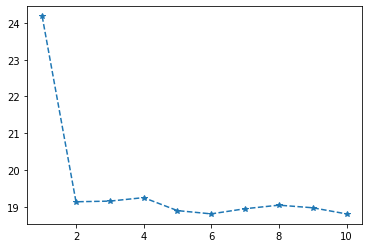

In [22]:
plt.plot(range(1,11), err, '--*')

## BOOTSTRAP

In [23]:
from sklearn.utils import resample

In [24]:
def alpha(X, y, index = None):
    if index is not None:
        X = X[index]
        y = y[index]
    return (np.var(y) - np.cov(X, y)[0,1]) / (np.var(X) + np.var(y) - 2*np.cov(X, y)[0,1])

In [25]:
df = get_rdataset('Portfolio', 'ISLR', cache=True).data

In [26]:
alpha(df.X, df.Y, range(100))

0.5766511516104116

In [27]:
train_idx = df.sample(n = 100, replace=True, random_state=17).index

In [28]:
alpha(df.X, df.Y, train_idx)

0.6523748564391235

In [29]:
def boot(data, func, n):
    alphas = []
    for i in range(n):
        index = data.sample(n = 100, replace = True).index
        alphas.append(func(data.X, data.Y, index))
    alphas = np.array(alphas)
    return alphas.std()/np.sqrt(len(alphas))

In [30]:
boot(df, alpha, 1000)

0.002885860071775077

In [31]:
df = get_rdataset('Auto', 'ISLR', True).data

In [32]:
def coefficients(data, index, ind_object = True):
    if ind_object:
        to_use = data.loc[index]
    else:
        to_use = data.iloc[index]
    X = add_constant(to_use.horsepower)
    model = lm.OLS(to_use.mpg, X).fit()
    
    return model.params

In [33]:
coefficients(df, range(392), False)

const         39.935861
horsepower    -0.157845
dtype: float64

In [34]:
coefficients(df, np.array(df.sample(n = 392, replace=True).index))

const         40.830131
horsepower    -0.167500
dtype: float64

In [35]:
coefficients(df, np.array(df.sample(n = 392, replace=True).index))

const         40.576062
horsepower    -0.164068
dtype: float64

In [36]:
def coefficients(data, index, ind_object = True):
    if ind_object:
        to_use = data.loc[index]
    else:
        to_use = data.iloc[index]
    X = add_constant(to_use.horsepower)
    model = lm.OLS(to_use.mpg, X).fit()
    
    return np.array(model.params)

def boot(data, func, n):
    coefs = []
    for i in range(n):
        index = np.array(df.sample(n = 392, replace=True, random_state=17).index)
        coefs.append(func(data, index))
    coefs = np.array(coefs)
    return coefs[:,0].std()/len(coefs), coefs[:, 1].std()/len(coefs)

In [37]:
coefficients(df, np.array(df.sample(n = 392, replace=True).index)).tolist()

[40.06947354982266, -0.16186309377251312]

In [38]:
boot(df, coefficients, 1000)

(7.105427357601002e-18, 2.7755575615628914e-20)

# >> LABS <<

## *Exercise 5*

In [40]:
df = get_rdataset('Default', 'ISLR', cache=True).data

In [46]:
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


In [54]:
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [55]:
df[["default", "student"]] = df[["default", "student"]].applymap(lambda x: 1 if x=='Yes' else 0)

In [56]:
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [104]:
np.random.seed(0)

train = df.sample(frac=0.5)
test = df.iloc[df.index.difference(train.index)]

In [105]:
X = add_constant(train[["balance", "income"]])
model = dm.Logit(train.default, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.084455
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4997
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Apr 2022   Pseudo R-squ.:                  0.4686
Time:                        19:31:15   Log-Likelihood:                -422.28
converged:                       True   LL-Null:                       -794.71
Covariance Type:            nonrobust   LLR p-value:                1.802e-162
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.6902      0.599    -19.523      0.000     -12.864     -10.517
balance        0.0057      0

In [125]:
def validate_model():
    train = df.sample(frac=0.5)
    test = df.iloc[df.index.difference(train.index)]
    
    X = add_constant(train[["balance", "income"]])
    model = dm.Logit(train.default, X).fit()
    
    pred = model.predict(add_constant(train[["balance", "income"]]))
    discrete_pred = pred.map(lambda x: round(x))
    
    mean = np.mean( discrete_pred!=train["default"] )
    print("test error from validation = ", np.mean( discrete_pred!=train["default"] ), end = "\n\n")
    return mean

In [126]:
x = 0
t = 5
for i in range(t):
    x+=validate_model()
print("\n")
print(f"mean validation test error = {x/t}")

Optimization terminated successfully.
         Current function value: 0.083025
         Iterations 10
test error from validation =  0.027

Optimization terminated successfully.
         Current function value: 0.079303
         Iterations 10
test error from validation =  0.0278

Optimization terminated successfully.
         Current function value: 0.082450
         Iterations 10
test error from validation =  0.0282

Optimization terminated successfully.
         Current function value: 0.077529
         Iterations 10
test error from validation =  0.0262

Optimization terminated successfully.
         Current function value: 0.078243
         Iterations 10
test error from validation =  0.0278



mean validation test error = 0.0274


In [127]:
pred = model.predict(add_constant(test[["balance", "income"]]))
discrete_pred = pred.map(lambda x: round(x))

print(discrete_pred.value_counts(), "\n\n",
      "test error from test = ", np.mean( discrete_pred!=test["default"] ), 
      sep = "")

0    4923
1      77
dtype: int64

test error from test = 0.024


## *Exercise 6*